In [1]:
import torch
import torchvision
from torch.nn import functional as F
import torch.nn as nn
from env import Name, MazeEnv
from model import LSTM, LSTM_Attn
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from util import Tester
from torchvision.transforms import Resize
from torchvision.transforms import InterpolationMode

# Load pretrained resnet

In [2]:
resnet18 = torchvision.models.resnet18(pretrained=True)
modules = list(resnet18.children())[:5]
img_encoder = nn.Sequential(*modules)
img_encoder.eval()
for p in img_encoder.parameters():
    p.requires_grad = False
# img_encoder.eval()


# Visualize input image

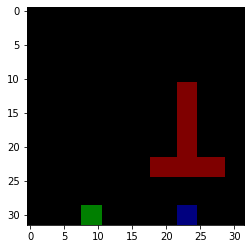

In [90]:
agent = LSTM_Attn(hidden_size=256, channel_size=64)
task = MazeEnv(resize=36)
img = task.transform(task.img())
plt.imshow(img.permute(1,2,0))

# Train

In [91]:
lr = 5e-4

agent = LSTM_Attn(hidden_size=256, channel_size=64)
optimizer = torch.optim.RMSprop(agent.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

losses = []
n_train = 20000

agent.train()
mem_state = agent.get_init_states()
for i in tqdm(range(n_train)):
    task = MazeEnv(resize=36)
    solution = task.get_solution()
    if solution == None:
        continue
    mem_state = mem_state[0].detach(), mem_state[1].detach()
    p_action = torch.zeros([1, 1, 4])
    loss = 0
    for target in solution:
        img = task.transform(task.img()).unsqueeze(0) 
        img = img_encoder(img)
        logit, mem_state = agent(img, p_action, mem_state)
        logit = logit.squeeze(0)  
        
        loss += criterion(logit, torch.tensor([target]))
        
        p_action = torch.eye(4)[int(target)].view(1, 1, -1)
        task.step(int(target))
        
    losses.append(loss.detach())
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if (i + 1) % 1000 == 0:
        torch.save(agent.state_dict(), 'checkpoint/rnn_%d' % (i + 1))
        

100%|█████████████████████████████████████| 20000/20000 [06:45<00:00, 49.30it/s]


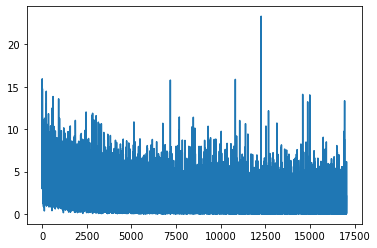

In [92]:
plt.plot(losses)

# Test
Random model: 4%

In [101]:
testset = [MazeEnv(length=9, resize=36) for _ in range(100)]

In [103]:
agent = LSTM_Attn(hidden_size=256, channel_size=64)
path = 'checkpoint/rnn_20000'
agent.load_state_dict(torch.load(path))
agent.eval()

limit = 10
correct = 0
n_test = 100
for task in tqdm(testset):
    mem_state = agent.get_init_states()
    p_action = torch.zeros([1, 1, 4])
    for _ in range(limit):
        img = task.transform(task.img()).unsqueeze(0)
        img = img_encoder(img)
        logit, mem_state = agent(img, p_action, mem_state)  
        logit = logit.flatten()
        action = logit.argmax().item()
        reward = task.step(action)
        if reward == 0:
            correct += 1
            break
        p_action = torch.eye(4)[action].view(1, 1, -1)
    task.reset()
    
print('Success rate %.2f%%' % (correct / len(testset) * 100) )
        

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 63.79it/s]

Success rate 65.00%


## Performance with training epochs

In [104]:
import os.path

testset = [MazeEnv(length=9,resize=36) for _ in range(100)]
x = []
accs1 = []
for i in tqdm(range(50)):
    agent = LSTM_Attn(hidden_size=256, channel_size=64)
    path = 'checkpoint/rnn_%d' % ((i + 1) * 1000)
    if os.path.exists(path):
        agent.load_state_dict(torch.load(path))
        tester = Tester(img_encoder, agent, testset)
        accs1.append(tester.run())
        x.append(1000 * (i+1))

testset = [MazeEnv(length=3, resize=18) for _ in range(100)]
accs2 = []
for i in tqdm(range(50)):
    agent = LSTM_Attn(hidden_size=256, channel_size=64)
    path = 'checkpoint/rnn_%d' % ((i + 1) * 1000)
    if os.path.exists(path):
        agent.load_state_dict(torch.load(path))
        tester = Tester(img_encoder, agent, testset)
        accs2.append(tester.run())

100%|███████████████████████████████████████████| 50/50 [00:24<00:00,  2.06it/s]


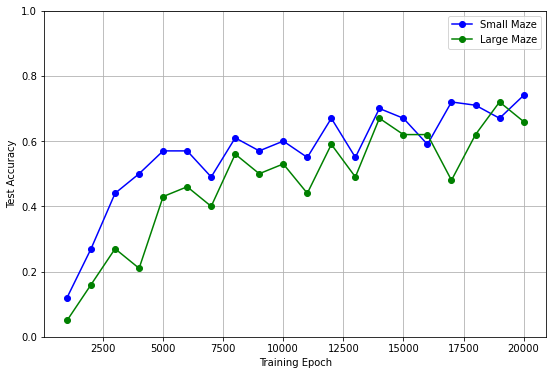

In [109]:
plt.figure(figsize=(9,6))
plt.plot(x, accs2[:20], 'b-o', label='Small Maze')
plt.plot(x, accs1[:20], 'g-o', label='Large Maze')

plt.grid()
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Test Accuracy')
plt.ylim(0,1)
plt.savefig('train_perform')

# Other


In [14]:
import os.path

os.path.exists('checkpoint/1e3')

False